# Installing Specific Analysis Packages

In [8]:
!pip install missingno
!pip install pandas-profiling
!pip install empiricaldist
!pip install factor-analyzer

## Loading Analysis Packages

In [9]:
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
import warnings
warnings.simplefilter("ignore")

import missingno as msno
%matplotlib inline

## Loading Data

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data at First Sight

In [11]:
train.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0


In [12]:
train.tail()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
969635,969636,NaN,NaN,Zimbabwe,14240168,0.607106,2020-06-08,Fatalities,0
969636,969637,NaN,NaN,Zimbabwe,14240168,0.060711,2020-06-09,ConfirmedCases,27
969637,969638,NaN,NaN,Zimbabwe,14240168,0.607106,2020-06-09,Fatalities,0
969638,969639,NaN,NaN,Zimbabwe,14240168,0.060711,2020-06-10,ConfirmedCases,6
969639,969640,NaN,NaN,Zimbabwe,14240168,0.607106,2020-06-10,Fatalities,0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969640 entries, 0 to 969639
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              969640 non-null  int64  
 1   County          880040 non-null  object 
 2   Province_State  917280 non-null  object 
 3   Country_Region  969640 non-null  object 
 4   Population      969640 non-null  int64  
 5   Weight          969640 non-null  float64
 6   Date            969640 non-null  object 
 7   Target          969640 non-null  object 
 8   TargetValue     969640 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 66.6+ MB


In [14]:
print("Train dataset (rows, cols):",train.shape, "\nTest dataset (rows, cols):",test.shape)

Train dataset (rows, cols): (969640, 9) 
Test dataset (rows, cols): (311670, 8)


In [15]:
profile_train_df = pdp.ProfileReport(train, 
                                      minimal = True, 
                                      explorative=True, 
                                      title = 'ProfilingResults',
                                      progress_bar=True)

In [16]:
profile_train_df

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Metadata

In [17]:
train.columns

Index(['Id', 'County', 'Province_State', 'Country_Region', 'Population',
       'Weight', 'Date', 'Target', 'TargetValue'],
      dtype='object')

In [20]:
data = []
for feature in train.columns:
    # Defining the role
    if feature == 'Target':
        role = 'target'
    elif feature == 'Id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if feature == 'Target':
        level = 'binary'
    elif feature == 'id':
        level = 'nominal'
    elif train[feature].dtype == float:
        level = 'interval'
    else:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if feature == 'Id':
        keep = False
    
    # Defining the data type 
    dtype = train[feature].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dict = {
        'varname': feature,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(feature_dict)
    
meta1 = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta1.set_index('varname', inplace=True)
meta1

,role,level,keep,dtype
varname,,,,
Id,id,ordinal,False,int64
County,input,ordinal,True,object
Province_State,input,ordinal,True,object
Country_Region,input,ordinal,True,object
Population,input,ordinal,True,int64
Weight,input,interval,True,float64
Date,input,ordinal,True,object
Target,target,binary,True,object
TargetValue,input,ordinal,True,int64


In [23]:
data = []
for feature in train.columns:
    # Defining the role
    if feature == 'Target':
        use = 'target'
    elif feature == 'Id':
        use = 'id'
    else:
        use = 'input'
         
    # Defining the type
    if feature == 'Target':
        type = 'binary'
    elif train[feature].dtype == float or isinstance(train[feature].dtype, float):
        type = 'real'
    elif train[feature].dtype == int or isinstance(train[feature].dtype, int):
        type = 'integer'
    else:
        type = 'categorical'
        
        
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'Id':
        preserve = False
    
    # Defining the data type 
    dtype = train[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'County' in feature or 'Province' in feature or 'Country' in feature:
        category = 'Area'
    
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
meta2 = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
meta2.set_index('varname', inplace=True)
meta2

,use,type,preserve,dtype,category
varname,,,,,
Id,id,categorical,False,int64,none
County,input,categorical,True,object,Area
Province_State,input,categorical,True,object,Area
Country_Region,input,categorical,True,object,Area
Population,input,categorical,True,int64,none
Weight,input,real,True,float64,none
Date,input,categorical,True,object,none
Target,target,binary,True,object,none
TargetValue,input,categorical,True,int64,none


In [24]:
meta2[(meta2.type == 'categorical') & (meta2.preserve)].index

Index(['County', 'Province_State', 'Country_Region', 'Population', 'Date',
       'TargetValue'],
      dtype='object', name='varname')

In [25]:
pd.DataFrame({'count' : meta2.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,Area,3
1,none,6


In [26]:
pd.DataFrame({'count' : meta2.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,categorical,6
2,input,real,1
3,target,binary,1


## Exploratory Data Analysis

### Data Quality Issues

#### Data Duplication

In [27]:
train.drop_duplicates()
train.shape

(969640, 9)

In [28]:
test.drop_duplicates()
test.shape

(311670, 8)

###### Observations:

Train has 969,640 rows and 9 variables. 
1 one missing variable in the Test (8 variables). 
no duplication in both Train and Test dataset.

#### Missing Values

In [29]:
def _impute_missing_data(data):
    return data.replace(-1, np.nan)

train = _impute_missing_data(train)
test = _impute_missing_data(test)

In [30]:
print('NaN values =', train.isnull().sum().sum())
print("""""")

vars_with_missing = []

for feature in train.columns:
    missings = train[feature].isna().sum()
    
    if missings > 0 :
        vars_with_missing.append(feature)
        missings_perc = missings / train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values.'.format(feature, missings, missings_perc))
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

NaN values = 145462

Variable County has 89600 records (9.24%) with missing values.
Variable Province_State has 52360 records (5.40%) with missing values.
Variable TargetValue has 3502 records (0.36%) with missing values.
In total, there are 3 variables with missing values


<AxesSubplot:>

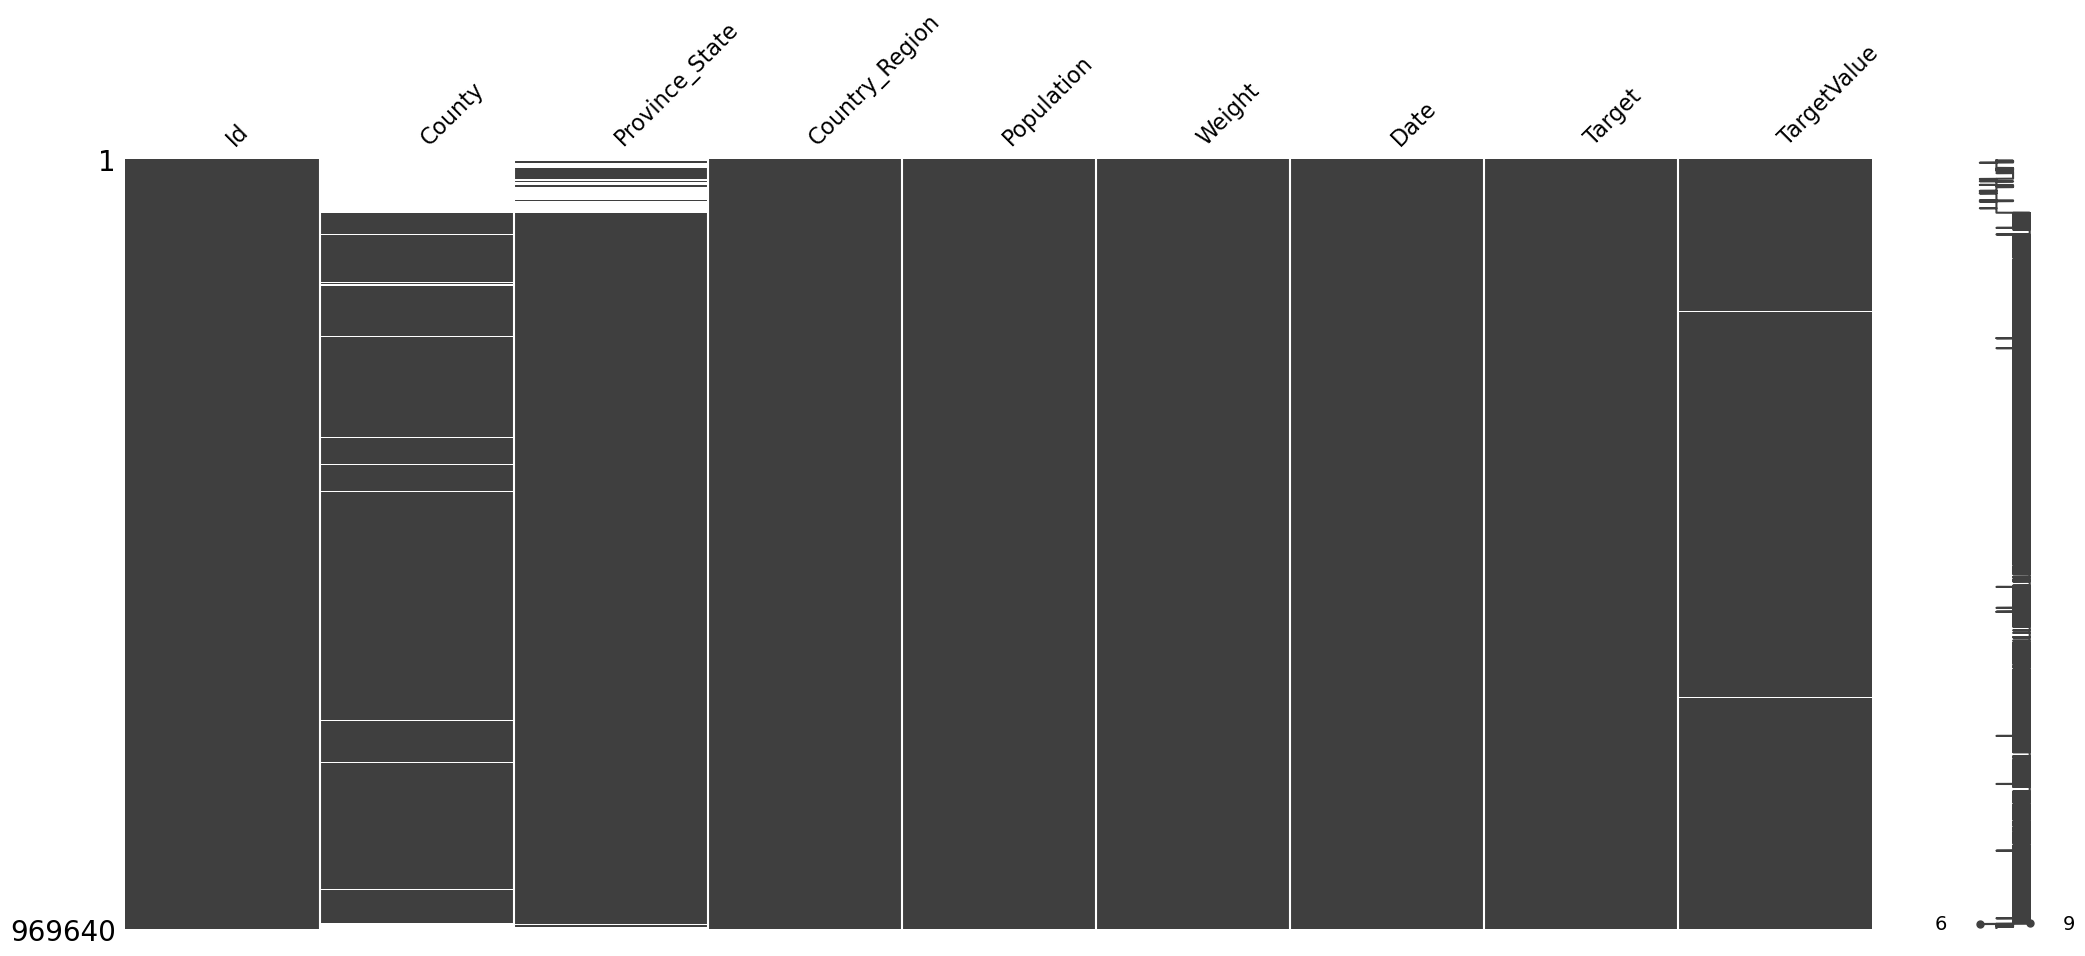

In [31]:
import missingno as msno  # Visualize missing values
%matplotlib inline
msno.matrix(train)

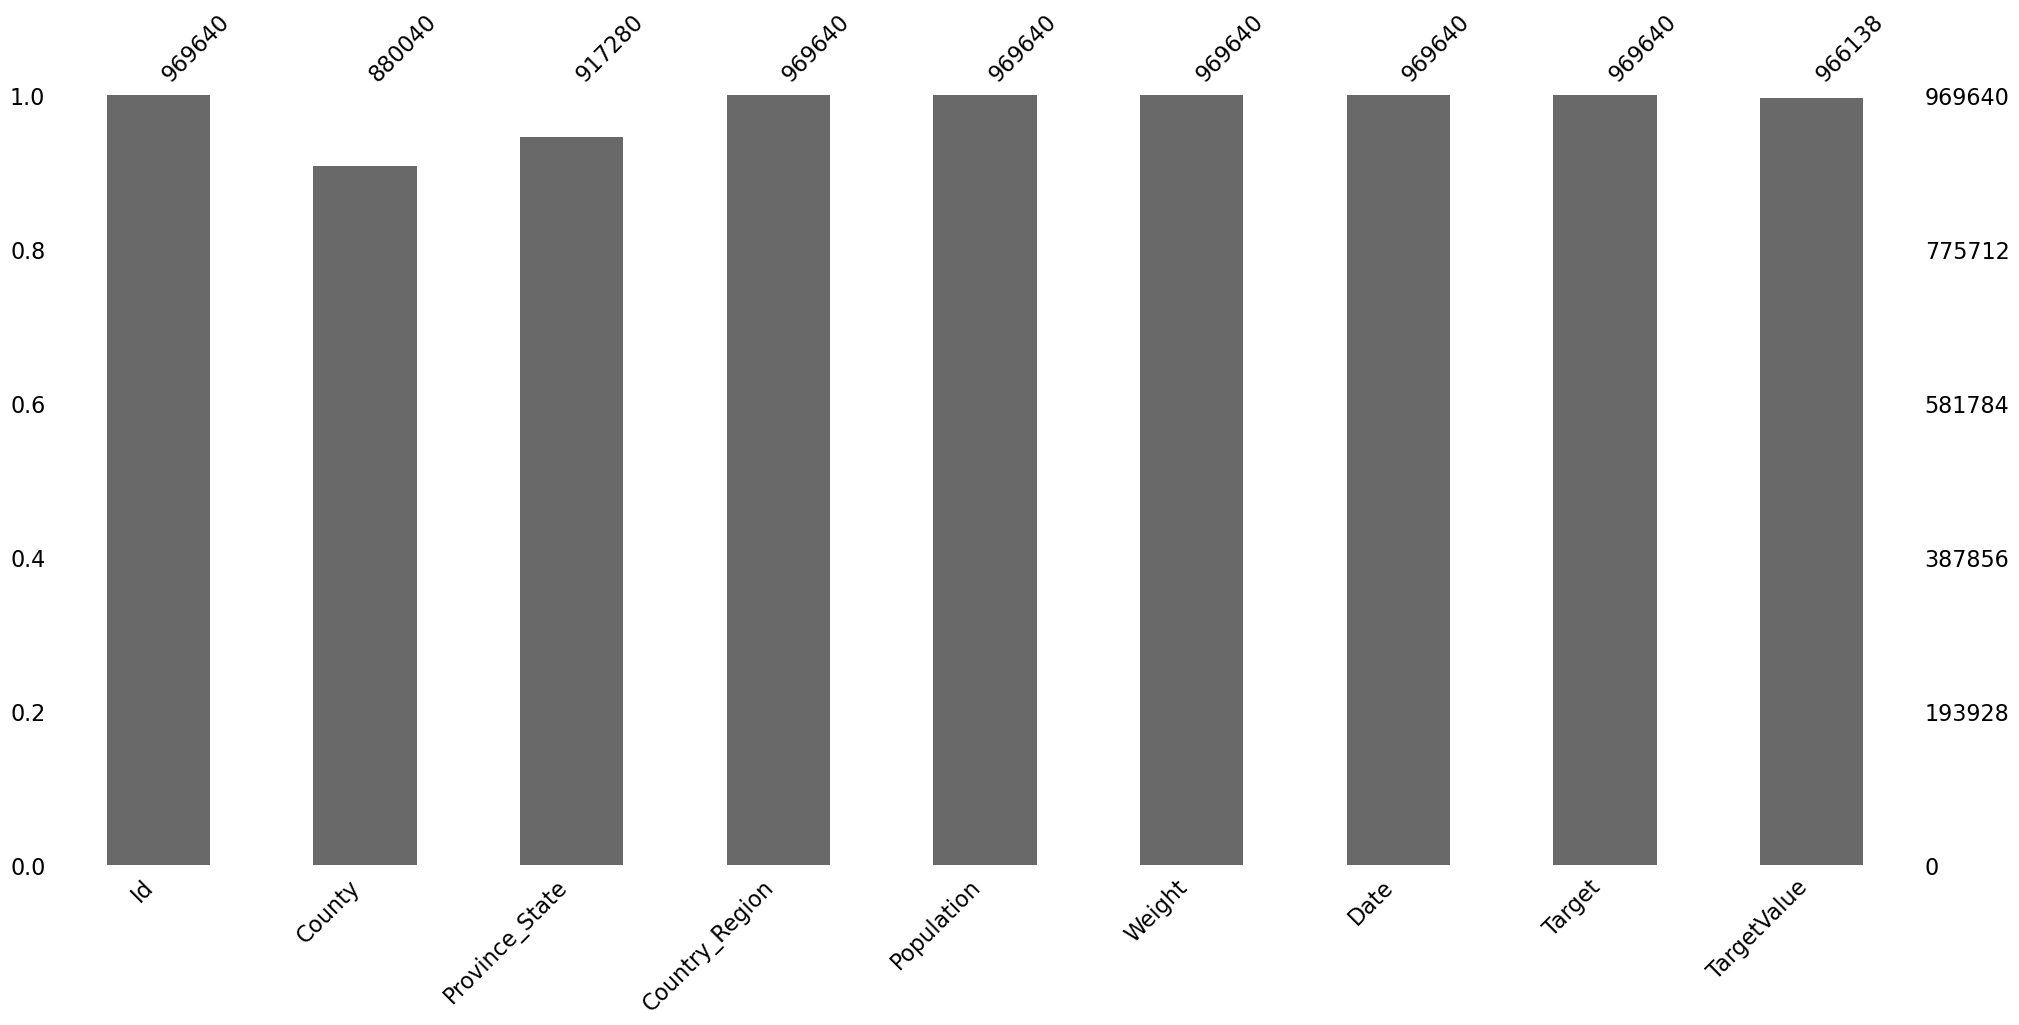

In [32]:
msno.bar(train);

<AxesSubplot:>

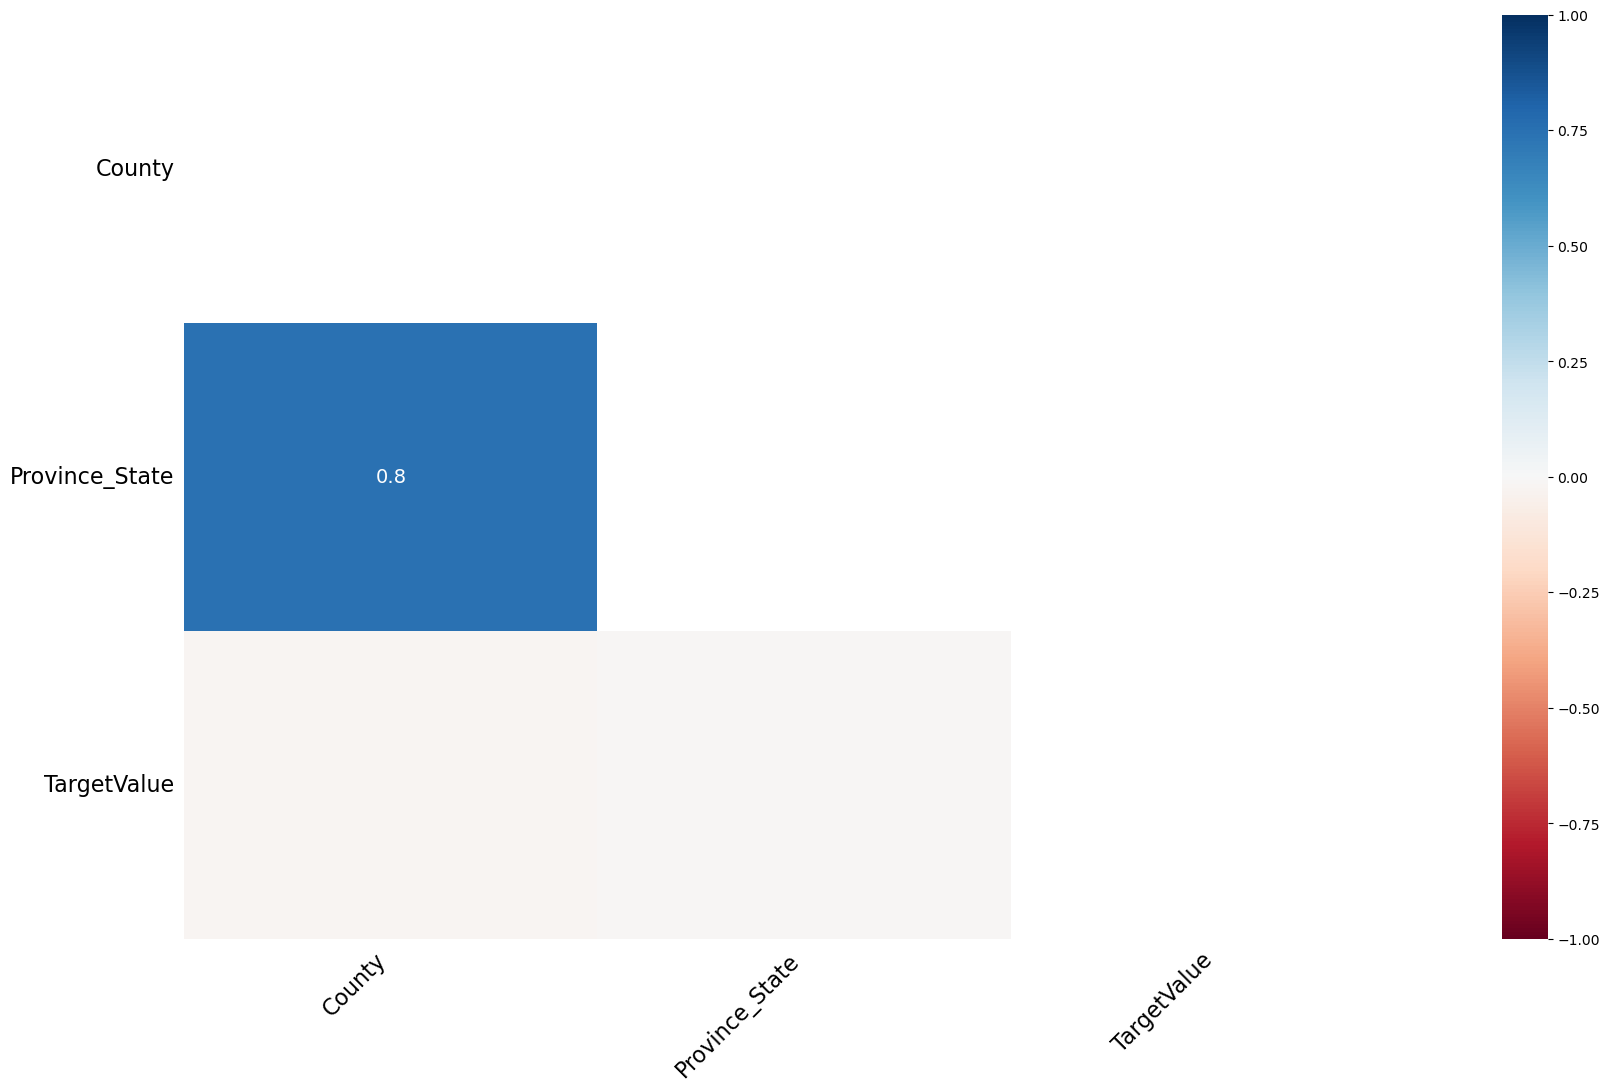

In [33]:
msno.heatmap(train)

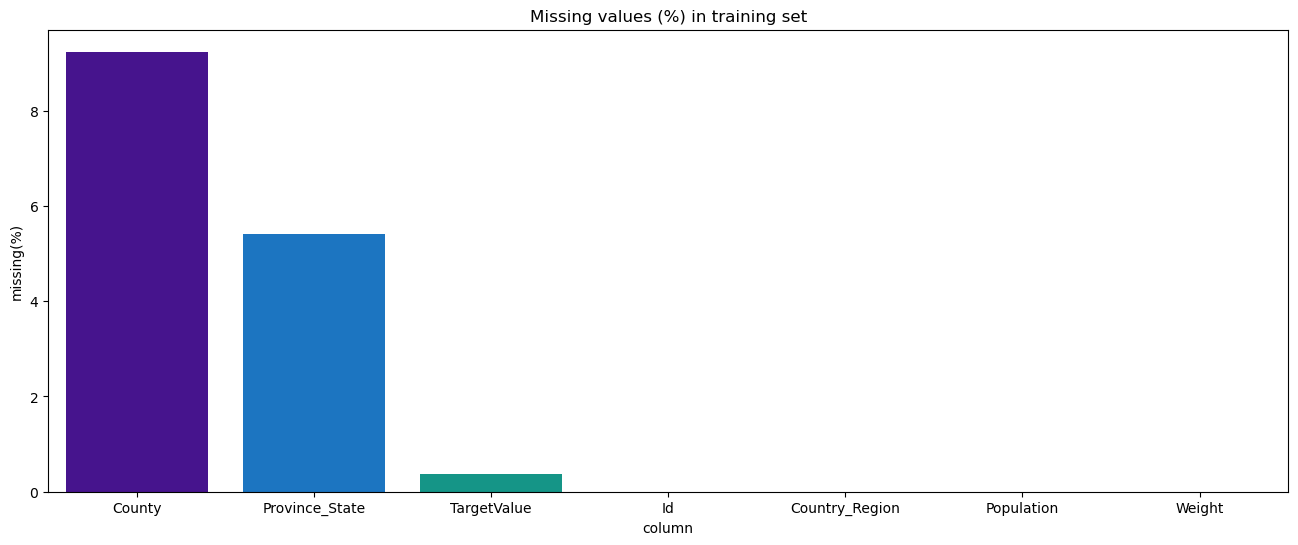

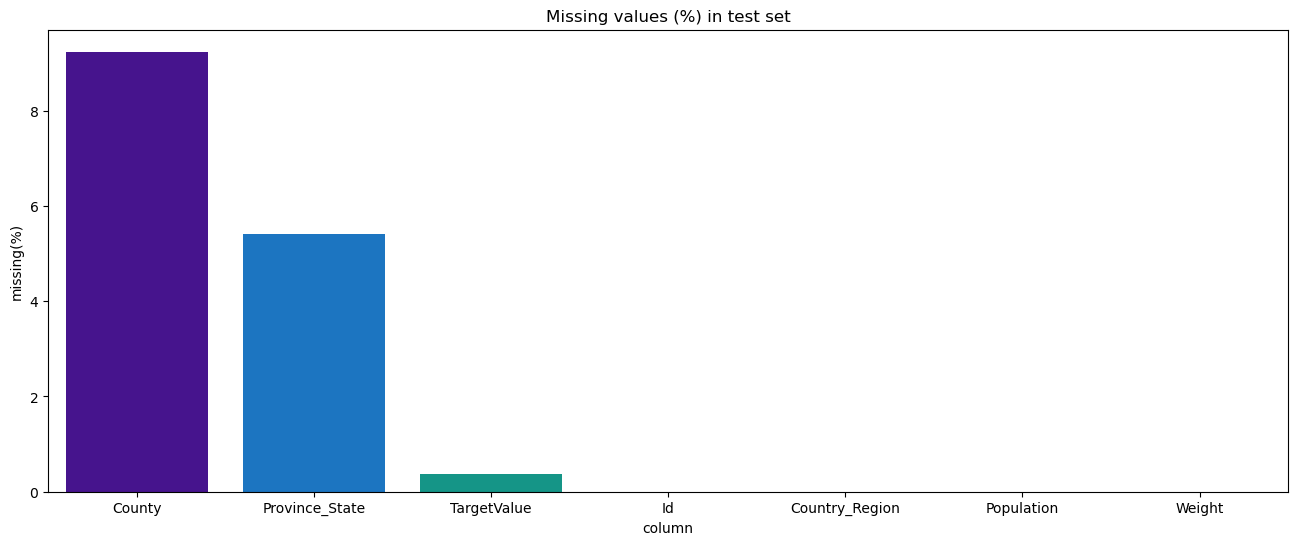

In [34]:
df_missing_train = pd.DataFrame({'column':train.columns, 'missing(%)':((train.isna()).sum()/train.shape[0])*100})
df_missing_test = pd.DataFrame({'column':train.columns, 'missing(%)':((train.isna()).sum()/train.shape[0])*100})

df_missing_train_nl = df_missing_train.nlargest(7, 'missing(%)')
df_missing_test_nl = df_missing_test.nlargest(7, 'missing(%)')

sns.set_palette(sns.color_palette('nipy_spectral'))

plt.figure(figsize=(16,6))
sns.barplot(data= df_missing_train_nl, x='column', y='missing(%)',palette='nipy_spectral')
plt.title('Missing values (%) in training set')
plt.show()

plt.figure(figsize=(16,6))
sns.barplot(data= df_missing_test_nl, x='column', y='missing(%)',palette='nipy_spectral')
plt.title('Missing values (%) in test set')
plt.show()

###### Observations
Missing value proportions tend to be consistent across the train and test dataset

## Univariate Exploration

### Binary features

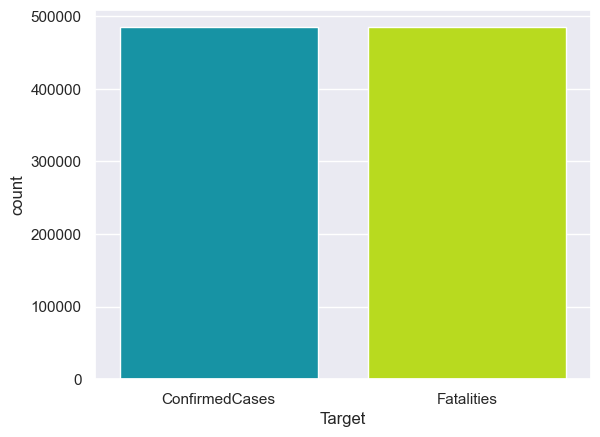

In [36]:
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=train['Target'],palette='nipy_spectral')
plt.show()

In [37]:
v = meta2[(meta2.type == 'binary') & (meta2.preserve)].index
train[v].describe()

,Target
count,969640
unique,2
top,ConfirmedCases
freq,484820
